In [49]:
import ARXT
from ARXT import hit_rate
import Data_gen
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import matplotlib.pyplot as plt
import logging
import bayesian_changepoint_detection.bayesian_models as bayes_models
from bayesian_changepoint_detection.hazard_functions import constant_hazard
import bayesian_changepoint_detection.online_likelihoods as online_ll
import time 
from numpy.linalg import lstsq


def get_data(differencing = False):

    # tickers = ["^GSPC", "^IXIC", "^DJI","JPYUSD=X", "^VIX", "GBPUSD=X", "EURUSD=X] # , "GBPUSD=X", "EURUSD=X",
    # data = data_gen.collect_data(tickers)
    data = pd.read_csv("../Data/fin_data.csv")
    # data.to_csv("data/fin_data.csv")
    data.index = data["Date"]
    data = data.pct_change()
    data = data.drop(["Date"], axis=1)
    data.columns = range(data.shape[1])
    if differencing:
        data = data.diff()
        data = data.iloc[1:,:]
    else:
        data = pd.DataFrame(np.log1p(data))

    return(data)


def train_run_tree(data, p, max_depth, min_size, max_weight, splt):
    p, max_depth, min_size =  int(round(p)), int(round(max_depth)), int(round(min_size))
    d_val_cumsum, valid_prediction_cumsum, tree_list = ARXT.ARXT_time_series_pred(data=data, p=p, preprocessing_method='normalization', max_depth=max_depth, min_size=min_size, max_weight=max_weight, splt=splt)
    hit_rate_sample = hit_rate(d_val_cumsum, valid_prediction_cumsum)

    rmse_sample = (sqrt(mean_squared_error(d_val_cumsum, valid_prediction_cumsum)))

    return d_val_cumsum, valid_prediction_cumsum, tree_list, hit_rate_sample, rmse_sample
DATA = get_data(differencing=True)

def objective_function(p, max_depth, min_size, max_weight, start, fin, splt):
    # Set up and train the ART model using the hyperparameters
    p, max_depth, min_size, max_weight =  round(p), round(max_depth), round(min_size), round(max_weight)
    d_val_cumsum, valid_prediction_cumsum, _, hit_rate_sample, rmse_sample = train_run_tree(DATA[start:fin], p, max_depth, min_size, max_weight, splt=splt)

    performance = hit_rate_sample * 2 - rmse_sample * 0.5
    return performance
def optimizer(pbounds, start, fin, splt, init_points=10, n_iter=30):
    optimizer = BayesianOptimization(f= lambda p, max_depth, min_size, max_weight: objective_function(p, max_depth, min_size, max_weight, start, fin, splt), pbounds=pbounds, random_state=1)
    acq_function = UtilityFunction(kind="ei", kappa=5, kappa_decay=0.8)
    optimizer.maximize(init_points, n_iter, acquisition_function = acq_function)
    opt_params  = optimizer.max['params']
    return opt_params
def ARXT_tree(splt, tune):
    start_time = time.time()
    train_len = 1000
    # Define hyperparameter bounds
    pbounds = {
        "p": (5, 20),
        "max_depth":(10, 150),
        "min_size":(1, 50),
        "max_weight": (0.01, 0.15)
    }
    opt_params = optimizer(pbounds, 0 , train_len, splt)
    p, max_depth, min_size, max_weight = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size']), opt_params['max_weight']
    next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3), "max_weight" : (max(0.001, max_weight*0.7), max_weight*1.3)}

    ART = ARXT.AutoregressiveTree(p, splt=splt)    

    _, _, tree, _, _ = train_run_tree(data=DATA.iloc[200:train_len], p=p, max_depth=max_depth, min_size=min_size, max_weight=max_weight, splt=splt)
    c_det = bayes_models.OnlineChagepoint(np.array(DATA[0]), constant_hazard, 200)
    log_likelihood_class = c_det.warm_run(llc = online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0),t = train_len)
    Nw = 200
    forecasts = []
    retraining_points = []
    for i in range(train_len, len(DATA[0])):
        forecasts.append(ARXT.forecast(DATA.iloc[i-200:i], tree, ART, p))

        if c_det.iteration(i, log_likelihood_class, Nw):
            print("retraining at ", DATA.index[i])
            retraining_points.append(DATA.index[i])
            if tune:
                opt_params = optimizer(next_pbounds, i-500, i, splt, init_points=5, n_iter = 10)
                p, max_depth, min_size, max_weight = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size']), opt_params['max_weight']
                next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3), "max_weight" : (max(0.001, max_weight*0.7), max_weight*1.3)}

            ART = ARXT.AutoregressiveTree(p, splt=splt)    
    
            _, _, tree, _, _ = train_run_tree(data=DATA[i-600:i], p=p, max_depth=max_depth, min_size=min_size, max_weight=max_weight, splt=splt)
    retrain = "retrain"
    if tune: retrain = "retune"
    pd.DataFrame(forecasts).to_csv("forecasts_{}_{}.csv".format(splt, retrain))
    pd.DataFrame(retraining_points).to_csv("retraining_points.csv".format(splt))

    plt.plot(DATA.iloc[train_len:,0], label="truth")
    plt.plot(forecasts, label="forecasts")
    plt.legend()
    plt.show()
    end_time = time.time()
    duration = end_time-start_time
    print("Time taken for ARXT {} {}: {}".format(splt, retrain, duration))
    return forecasts, retraining_points

# ARTX_exog_tuned, retraining_points = ARXT_tree("exog", True)


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [51]:
data = pd.read_csv("../Data/fin_data.csv")
    # data.to_csv("data/fin_data.csv")
data.index = data["Date"]
data = data.drop(["Date"], axis=1)
data = data.pct_change()

data.columns = range(data.shape[1])
# if differencing:
#     data = data.diff()
#     data = data.iloc[1:,:]
# else:
#     data = pd.DataFrame(np.log1p(data))



TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [44]:
train_len = 1000
# c_det = bayes_models.OnlineChagepoint(np.array(DATA[0]), constant_hazard, 125)
# log_likelihood_class = c_det.warm_run(llc = online_ll.StudentT(alpha=0.5, beta=.01, kappa=0.1, mu=0),t = train_len)
cps = pd.read_csv('../Data/changepoints.csv')
cps = cps.to_numpy()
Nw = 200
for i in range(train_len, len(DATA[0])):
    if DATA.index[i] in cps:
        
        print("retraining at ", DATA.index[i])

retraining at  2008-09-19
retraining at  2010-05-11
retraining at  2011-08-10
retraining at  2015-08-27
retraining at  2018-12-27
retraining at  2020-03-03
retraining at  2022-11-11


In [45]:
DATA

,0,1,2,3,4,5,6,7,8
Date,,,,,,,,,
2003-01-02,29.210022,-0.000105,265.889648,49.339966,-3.230001,0.029400,0.037600,-2285.714286,0.00
2003-01-03,-0.440002,0.000038,-5.829102,2.229980,-0.709999,0.003300,-0.071200,-2285.714286,-0.02
2003-01-06,20.419983,0.000022,171.879883,34.239990,0.230000,0.092200,0.050400,-6571.428571,0.01
2003-01-07,-6.080017,-0.000060,-32.980469,10.250000,0.219999,-0.015800,0.037200,-2142.857143,-0.01
2003-01-08,-13.000000,0.000078,-145.280273,-30.500000,0.400002,-0.028400,-0.052100,-2142.857143,0.09
...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,-0.000025,0.000000,0.000000,0.000000,-0.002880,0.002990,-1857.142857,0.00
2022-12-27,-15.570068,0.000001,37.628906,-144.629883,0.779999,-0.000285,-0.005675,-1000.000000,0.06
2022-12-28,-46.030029,-0.000041,-365.847656,-139.940430,0.490000,-0.000760,0.000355,-1000.000000,0.02


In [46]:
data = DATA.pct_change(1).diff()


,Date
0,2008-09-19
1,2010-05-11
2,2011-08-10
3,2015-08-27
4,2018-12-27
5,2020-03-03
6,2022-11-11


In [19]:
# print(pd.to_datetime(first, format="%Y-%m-%d"))
# first = cps.iloc[0]
first = cps.iloc[0]

In [38]:
str(first)

'Date    2008-09-19\nName: 0, dtype: object'

In [37]:
DATA.index[1492]

'2008-09-22'

In [31]:
DATA[:'2008-09-19']

,0,1,2,3,4,5,6,7,8
Date,,,,,,,,,
2003-01-02,29.210022,-0.000105,265.889648,49.339966,-3.230001,0.0294,0.0376,-2285.714286,0.00
2003-01-03,-0.440002,0.000038,-5.829102,2.229980,-0.709999,0.0033,-0.0712,-2285.714286,-0.02
2003-01-06,20.419983,0.000022,171.879883,34.239990,0.230000,0.0922,0.0504,-6571.428571,0.01
2003-01-07,-6.080017,-0.000060,-32.980469,10.250000,0.219999,-0.0158,0.0372,-2142.857143,-0.01
2003-01-08,-13.000000,0.000078,-145.280273,-30.500000,0.400002,-0.0284,-0.0521,-2142.857143,0.09
...,...,...,...,...,...,...,...,...,...
2008-09-15,-59.000000,0.000328,-504.480469,-81.360107,6.040001,0.1338,0.3203,10857.142857,-0.18
2008-09-16,20.900024,-0.000115,141.509766,27.989990,-1.400002,-0.0131,-0.0124,4857.142857,-0.14
2008-09-17,-57.209961,0.000109,-449.359375,-109.049805,5.920002,0.0194,0.0316,4857.142857,-0.03


In [170]:
from bayesian_changepoint_detection.priors import const_prior, geom_prior, negative_binomial_prior
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from functools import partial

prior_function = partial(const_prior)
data = DATA
truncate=-40
log_likelihood_class = offline_ll.StudentT()

In [168]:
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection

# Q, P, Pcp = offline_changepoint_detection(data, prior_function ,
# ,truncate=-40)

In [174]:
import time
# def offline_changepoint_detection(
#     data, prior_function, log_likelihood_class, truncate: int = -40
# ):
"""
Compute the likelihood of changepoints on data.

Parameters:
data    -- the time series data
truncate  -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood

Outputs:
    P  -- the log-likelihood of a datasequence [t, s], given there is no changepoint between t and s
    Q -- the log-likelihood of data
    Pcp --  the log-likelihood that the i-th changepoint is at time step t. To actually get the probility of a changepoint at time step t sum the probabilities.
"""

# Set up the placeholders for each parameter
n = len(data)
Q = np.zeros((n,))
g = np.zeros((n,))
G = np.zeros((n,))
P = np.ones((n, n)) * -np.inf
start = time.time()

# save everything in log representation
for t in range(n):
    g[t] = prior_function(t)
    if t == 0:
        G[t] = g[t]
    else:
        G[t] = np.logaddexp(G[t - 1], g[t])

P[n - 1, n - 1] = log_likelihood_class.pdf(data, t=n - 1, s=n)
Q[n - 1] = P[n - 1, n - 1]
print(f"log representation took {time.time()-start}")

start = time.time()

for t in reversed(range(n - 1)):
    P_next_cp = -np.inf  # == log(0)
    for s in range(t, n - 1):
        P[t, s] = log_likelihood_class.pdf(data, t=t, s=s + 1)

        # compute recursion
        summand = P[t, s] + Q[s + 1] + g[s + 1 - t]
        P_next_cp = np.logaddexp(P_next_cp, summand)

        # truncate sum to become approx. linear in time (see
        # Fearnhead, 2006, eq. (3))
        if summand - P_next_cp < truncate:
            break

    P[t, n - 1] = log_likelihood_class.pdf(data, t=t, s=n)

    # (1 - G) is numerical stable until G becomes numerically 1
    if G[n - 1 - t] < -1e-15:  # exp(-1e-15) = .99999...
        antiG = np.log(1 - np.exp(G[n - 1 - t]))
    else:
        # (1 - G) is approx. -log(G) for G close to 1
        antiG = np.log(-G[n - 1 - t])

    Q[t] = np.logaddexp(P_next_cp, P[t, n - 1] + antiG)
print(f"reversed took {time.time()-start}")
Pcp = np.ones((n - 1, n - 1)) * -np.inf
for t in range(n - 1):
    Pcp[0, t] = P[0, t] + Q[t + 1] + g[t] - Q[0]
    if np.isnan(Pcp[0, t]):
        Pcp[0, t] = -np.inf
for j in range(1, n - 1):
    for t in range(j, n - 1):
        tmp_cond = (
            Pcp[j - 1, j - 1 : t]
            + P[j : t + 1, t]
            + Q[t + 1]
            + g[0 : t - j + 1]
            - Q[j : t + 1]
        )
        Pcp[j, t] = logsumexp(tmp_cond.astype(np.float32))
        if np.isnan(Pcp[j, t]):
            Pcp[j, t] = -np.inf

# return Q, P, Pcp

log representation took 0.055320024490356445


KeyboardInterrupt: 

In [173]:
log_likelihood_class.pdf(data, t=t, s=s + 1)


-1303.868594800518

In [55]:
R = pd.read_csv('../R_mat.csv')
rotated = pd.DataFrame(np.rot90(R))
rotated.index = DATA.index[1000-1:]


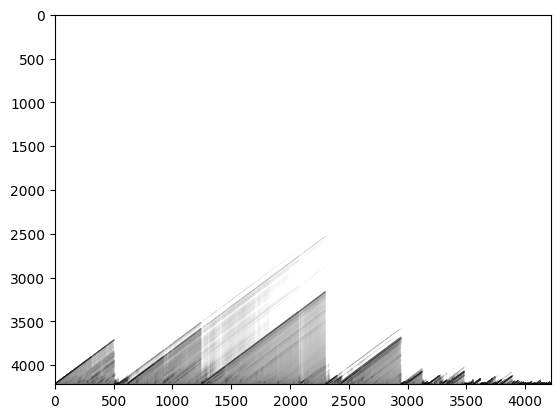

In [41]:
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
# plot = plt.subplot()
# plot.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
#                norm=LogNorm(vmin=0.0001, vmax=1))
plt.imshow(rotated, aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=0.1))
plt.axis = rotated.index
plt.show()

In [1]:
get_data(differencing=True)

NameError: name 'get_data' is not defined

In [84]:
import numpy as np
def get_changepoint_indices(R, train_len, threshold=0.8, min_distance=100):
    # R is the run length probability matrix from the BOCD algorithm
    # threshold is the minimum probability to consider for a changepoint
    changepoint_indices = np.where(R[:, 1] > threshold)[0]
    changepoint_indices.sort()

    # Filter out changepoints that are too close to each other
    filtered_cps = []
    last_cp = -min_distance  # Initialize with a value min_distance less than the first index
    
    for cp in changepoint_indices:
        if cp - last_cp >= min_distance:
            filtered_cps.append(cp+train_len)
            last_cp = cp

    return filtered_cps
changepoints = get_changepoint_indices(np.array(R), train_len=1000)

In [85]:
DATA.index[changepoints]

Index(['2006-11-03', '2008-10-14', '2015-08-27', '2020-03-03', '2020-09-04',
       '2022-01-31', '2022-09-14'],
      dtype='object', name='Date')

In [54]:
R[R ==max(np.array(R)[1:,0])].count()

0       1049
1          0
2          0
3          0
4          0
        ... 
4213       0
4214       0
4215       0
4216       0
4217       0
Length: 4218, dtype: int64